In [2]:
import torch
import torch.nn.functional as F
import numpy as np
from typing import Dict, List, Tuple, Optional, Union
import logging
from dataclasses import dataclass
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy

from utils import *

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [3]:
@dataclass
class BoundaryResult:
    """Results from boundary tracing experiment"""
    delta_min: float  # Minimal perturbation norm
    perturbation: torch.Tensor  # The actual perturbation vector
    original_code: torch.Tensor  # Original sparse code
    perturbed_code: torch.Tensor  # Code after perturbation
    flipped_features: List[Tuple[int, str]]  # (feature_idx, flip_type: 'activate'|'deactivate')
    num_steps: int  # Number of optimization steps
    num_boundaries_crossed: int  # Number of intermediate boundaries crossed
    boundary_type: str  # Type of boundary crossed
    target_reached: bool  # Whether target was reached
    trajectory: List[torch.Tensor]  # Trajectory of perturbations
    # New diagnostic fields
    cosine_similarity: float  # Cosine similarity between source and target
    relu_flips: int  # Number of ReLU pattern changes
    sae_flips: int  # Number of SAE feature changes
    trajectory_hidden: List[torch.Tensor]  # Trajectory of hidden states


class SAEBoundaryTracer:
    """
    Refined implementation of decision boundary tracing for Sparse Autoencoders.
    Enhanced with stability improvements and better diagnostics.
    """
    
    def __init__(self, sae_model, tokenizer, base_model=None, device='cpu', 
                 normalize_hidden=False, epsilon=1e-8, max_step_size=1.0):
        """Initialize boundary tracer with refined parameters."""
        self.sae = sae_model
        self.tokenizer = tokenizer
        self.base_model = base_model
        self.device = device
        self.normalize_hidden = normalize_hidden  # Whether to normalize hidden states
        self.epsilon = epsilon  # Numerical stability parameter
        self.max_step_size = max_step_size  # Maximum step size for stability
    
    def get_hidden_representation(self, text: str, layer_idx: int) -> torch.Tensor:
        """Extract hidden representation from base model at specified layer."""
        if self.base_model is None:
            raise ValueError("Base model required for extracting hidden representations")
        
        post_text = "\nThe previous text is about"
        tokens = self.tokenizer(text + post_text, return_tensors="pt")
        input_ids = tokens['input_ids'].to(self.device)
        
        with torch.no_grad():
            outputs = self.base_model(input_ids, output_hidden_states=True)
            hidden_state = outputs.hidden_states[layer_idx + 1][0, -1, :]
        
        # REFINED: Apply normalization if enabled
        if self.normalize_hidden:
            hidden_state = F.layer_norm(hidden_state, hidden_state.shape[-1:])
        
        return hidden_state.detach()
    
    def get_sae_code(self, hidden_state: torch.Tensor) -> torch.Tensor:
        """Get sparse code from SAE encoder with optional normalization."""
        # REFINED: Ensure consistent normalization
        if self.normalize_hidden:
            hidden_state = F.layer_norm(hidden_state, hidden_state.shape[-1:])
        
        sparse_code = jump_relu(hidden_state @ sae['W_enc'] + sae['b_enc'], sae['threshold'])
        return sparse_code
    
    def get_top_k_active_set(self, sparse_code: torch.Tensor, k: int = None) -> torch.Tensor:
        """Get indices of top-k active features with corrected logic."""
        if k is None:
            # REFINED: Use original indices for active features (not sorted)
            return (sparse_code > 0).nonzero(as_tuple=True)[0]
        else:
            # Get top-k by magnitude (sorted)
            sorted_acts, indices = torch.sort(sparse_code, dim=-1, descending=True)
            return indices[:k]

In [4]:
import sys
from sae import Sae
from utils import *
from transformers import AutoModelForCausalLM, AutoTokenizer, LlamaForCausalLM
import torch
import torch.nn.functional as F

import os
os.environ["https_proxy"] = "http://xen03.iitd.ac.in:3128"
os.environ["http_proxy"] = "http://xen03.iitd.ac.in:3128"

model_type = 'gemma2-2b'
layer_num = 20
device = 'cpu'

print("Loading model and SAE...")
model, tokenizer, sae = load_model_and_sae(model_type, layer_num, device)

# %%
# Test cases
education_text = 'The film explores love and trauma through non-linear storytelling, blending magical realism with emotionally raw performances'
technology_text = 'The film explores love and trauma through non-linear storytelling, blending magical realism with emotionally raw performancesHacker Encryption implementations'

# Initialize corrected tracer
tracer = SAEBoundaryTracer(sae, tokenizer, model, device=device, normalize_hidden=False)


Loading model and SAE...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
# Test with single concept pair
source_text = education_text
target_text = technology_text

print(f"Source: '{source_text[:-50]}...'")
print(f"Target: '{target_text[:-50]}...'")
print()

# Get hidden representations
source_hidden = tracer.get_hidden_representation(source_text, layer_num)
target_hidden = tracer.get_hidden_representation(target_text, layer_num)

Source: 'The film explores love and trauma through non-linear storytelling, blending...'
Target: 'The film explores love and trauma through non-linear storytelling, blending magical realism with emotionally...'



In [6]:
def support_jaccard(code1, code2):
    s1 = (code1 > 0).float()
    s2 = (code2 > 0).float()
    intersection = (s1 * s2).sum()
    union = (s1 + s2).clamp(max=1).sum()
    return (intersection / union).item() if union.item() > 0 else 1.0


# Hidden states

In [7]:
def analyze_hidden_polytope_transition(
    source_hidden: torch.Tensor,
    target_hidden: torch.Tensor,
    max_iter: int = 1000,
    step_size: float = 0.01,
    stall_patience: int = 5000,
    min_step_size: float = 0.001,
    max_step_size: float = 0.2,
    verbose: bool = True
) -> dict:
    """
    Analyze transitions between ReLU polytopes in hidden space,
    constraining each optimization step to cross at most 1 boundary.

    Each ReLU polytope is defined by the sign pattern (h > 0).

    Tracks:
    - Number of unique polytopes visited
    - Per-step boundary control (1 flip per step)
    - Hamming to target ReLU support
    - Cosine annealing step size when stalled

    Args:
        stall_patience: Number of steps to wait before applying cosine annealing
        min_step_size: Minimum step size for cosine annealing
        max_step_size: Maximum step size for cosine annealing
    """
    import math
    
    delta = torch.zeros_like(source_hidden, requires_grad=True)
    target_support = (target_hidden > 0).float()
    previous_support = (source_hidden > 0).float()

    visited_polytopes = set()
    visited_polytopes.add(tuple(previous_support.cpu().numpy().astype(int).tolist()))
    trajectory = []

    best_delta = None
    best_loss = float('inf')
    best_hamming = (previous_support != target_support).sum().item()
    
    # Stall tracking
    last_improvement_step = 0
    stall_counter = 0
    current_step_size = step_size
    
    step = 0
    while True:
        step += 1
        current_hidden = source_hidden + delta
        current_support = (current_hidden > 0).float()
        support_tuple = tuple(current_support.cpu().numpy().astype(int).tolist())

        # Log new polytope entry
        if support_tuple not in visited_polytopes:
            visited_polytopes.add(support_tuple)

            if verbose and step % 20 == 0:
                differences = current_support - previous_support
                activated = (differences > 0).nonzero(as_tuple=True)[0]
                deactivated = (differences < 0).nonzero(as_tuple=True)[0]
                print(f"Step {step}: New hidden polytope entered (#{len(visited_polytopes)})")
                if len(activated) > 0:
                    print(f"  Activated dims: {activated[:5].tolist()}...")
                if len(deactivated) > 0:
                    print(f"  Deactivated dims: {deactivated[:5].tolist()}...")

        previous_support = current_support.clone()

        # Compute loss and gradients
        loss = F.mse_loss(current_hidden, target_hidden)
        hamming = (current_support != target_support).sum().item()
        
        # Check for improvement
        improvement_made = False
        if loss.item() < best_loss or hamming < best_hamming:
            if loss.item() < best_loss:
                best_loss = loss.item()
                best_delta = delta.detach().clone()
            if hamming < best_hamming:
                best_hamming = hamming
            last_improvement_step = step
            stall_counter = 0
            improvement_made = True
        else:
            stall_counter += 1
        
        # Apply cosine annealing if stalled
        if stall_counter >= stall_patience:
            # Cosine annealing formula
            cosine_factor = 0.5 * (1 + math.cos(math.pi * (stall_counter - stall_patience) / stall_patience))
            current_step_size = min_step_size + (max_step_size - min_step_size) * cosine_factor
            
            if verbose and stall_counter % 10000 == 0:
                print(f"🔄 Step {step}: Applying cosine annealing, step_size = {current_step_size:.6f}")
                print(f"   Stalled for {stall_counter} steps, last improvement at step {last_improvement_step}")
        # else:
        #     current_step_size = step_size
        
        loss.backward()

        with torch.no_grad():
            grad = delta.grad
            proposed_step = -current_step_size * grad  # Use dynamic step size

            # Estimate new support if we take full step
            next_code = source_hidden + delta + proposed_step
            next_support = (next_code > 0).float()
            flip_mask = (next_support != current_support).float()

            # If more than one bit would flip, scale down
            flip_count = flip_mask.sum().item()
            if flip_count > 1:
                # Shrink the step to only allow the most sensitive unit to flip
                signs = current_hidden.sign()
                distances = current_hidden.abs() / (proposed_step.abs() + 1e-8)
                distances[proposed_step == 0] = float('inf')
                distances[signs != -proposed_step.sign()] = float('inf')  # only count approaching boundaries
                best_idx = distances.argmin()
                scale = (current_hidden[best_idx].abs() / proposed_step[best_idx].abs()).item()
                proposed_step = proposed_step * (scale + 1e-4)  # small nudge over boundary

            delta.add_(proposed_step)
            delta.grad.zero_()

        trajectory.append(delta.detach().clone())

        if verbose and step % 50 == 0:
            print(f"Step {step}: loss = {loss.item():.6f}, ||δ|| = {delta.norm().item():.6f}, "
                  f"visited polytopes = {len(visited_polytopes)}, hamming = {hamming}, "
                  f"step_size = {current_step_size:.6f}, stall = {stall_counter}")

        if loss.item() < 1e-6 and hamming == 0:
            if verbose:
                print(f"✅ Target hidden reached at step {step}")
                print(f"Hamming distance to target ReLU support: {hamming}")
            break

    return {
        'delta_min': best_delta.norm().item() if best_delta is not None else delta.norm().item(),
        'perturbation': best_delta if best_delta is not None else delta.detach(),
        'num_steps': step,
        'hidden_polytope_boundaries_crossed': len(visited_polytopes) - 1,
        'target_reached': best_loss < 1e-3,
        'final_loss': best_loss,
        'trajectory': trajectory,
        'visited_polytope_count': len(visited_polytopes),
        'last_improvement_step': last_improvement_step,
        'final_step_size': current_step_size,
        'stall_counter': stall_counter
    }

In [8]:
print(f"Source hidden shape: {source_hidden.shape}")
print(f"Target hidden shape: {target_hidden.shape}")

# Original polytope analysis
source_polytope = (source_hidden > 0).float()
target_polytope = (target_hidden > 0).float()
polytope_hamming = (source_polytope != target_polytope).sum().item()

print(f"Source polytope active dims: {source_polytope.sum().item()}/{len(source_polytope)}")
print(f"Target polytope active dims: {target_polytope.sum().item()}/{len(target_polytope)}")
print(f"Polytope Hamming distance: {polytope_hamming}")
print()

# Run corrected analysis
print("Running CORRECTED hidden polytope transition analysis...")
result = analyze_hidden_polytope_transition(
    source_hidden, target_hidden, 
    max_iter=10000, 
    verbose=True
)

print(f"\n=== CORRECTED RESULTS ===")
print(f"Minimal perturbation: {result['delta_min']:.6f}")
print(f"Hidden polytope boundaries crossed: {result['hidden_polytope_boundaries_crossed']}")
print(f"Target reached: {result['target_reached']}")
print(f"Final loss: {result['final_loss']:.6f}")
print(f"Optimization steps: {result['num_steps']}")

Source hidden shape: torch.Size([2304])
Target hidden shape: torch.Size([2304])
Source polytope active dims: 1142.0/2304
Target polytope active dims: 1125.0/2304
Polytope Hamming distance: 595

Running CORRECTED hidden polytope transition analysis...
Step 50: loss = 11.892805, ||δ|| = 0.071861, visited polytopes = 1, hamming = 595, step_size = 0.010000, stall = 0
Step 100: loss = 11.882486, ||δ|| = 0.143691, visited polytopes = 2, hamming = 594, step_size = 0.010000, stall = 0
Step 150: loss = 11.872176, ||δ|| = 0.215489, visited polytopes = 2, hamming = 594, step_size = 0.010000, stall = 0
Step 200: loss = 11.861875, ||δ|| = 0.287257, visited polytopes = 2, hamming = 594, step_size = 0.010000, stall = 0
Step 250: loss = 11.851582, ||δ|| = 0.358993, visited polytopes = 2, hamming = 594, step_size = 0.010000, stall = 0
Step 300: loss = 11.841299, ||δ|| = 0.430699, visited polytopes = 2, hamming = 594, step_size = 0.010000, stall = 0
Step 350: loss = 11.831024, ||δ|| = 0.502373, visited 

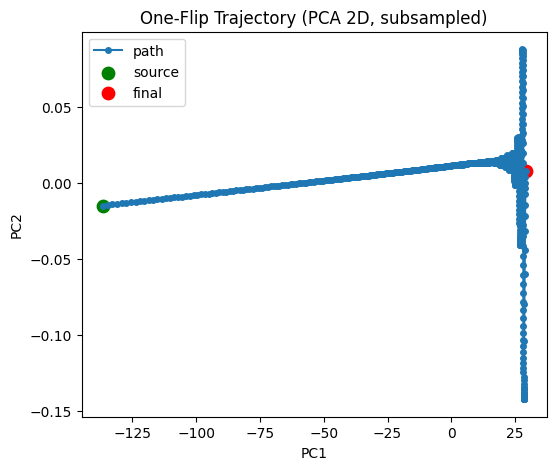

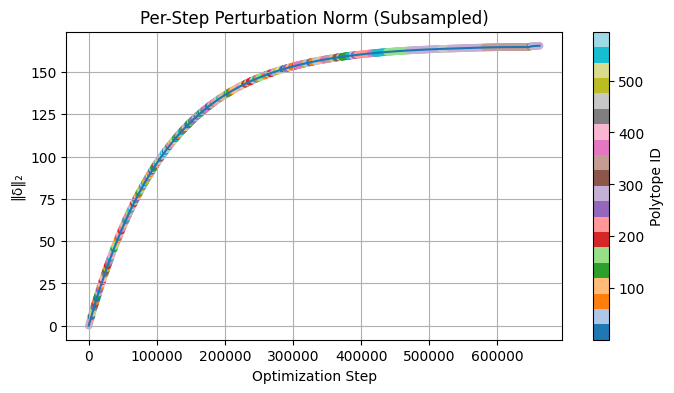

In [28]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_oneflip_trajectory(source_hidden, result, n_components=2, max_points=500):
    """
    PCA-based 2D trajectory plot for the one-flip optimization, with subsampling.
    """
    source_np = source_hidden.detach().cpu().numpy()
    # Stack deltas and subsample
    deltas = np.stack([d.detach().cpu().numpy() for d in result['trajectory']])
    N, D = deltas.shape
    if N > max_points:
        idxs = np.linspace(0, N-1, max_points, dtype=int)
        deltas_sub = deltas[idxs]
    else:
        idxs = np.arange(N)
        deltas_sub = deltas

    # Reconstruct corresponding hidden states
    hidden_sub = deltas_sub + source_np[None, :]
    end_np = source_np + result['perturbation'].detach().cpu().numpy()

    # Build PCA dataset on subsample + endpoints
    all_states = np.vstack([source_np, hidden_sub, end_np])
    mean = all_states.mean(axis=0)
    centered = all_states - mean
    # SVD for PCA
    U, S, Vt = np.linalg.svd(centered, full_matrices=False)
    comps = Vt[:n_components]
    coords = centered.dot(comps.T)

    # Plot trajectory
    plt.figure(figsize=(6,5))
    plt.plot(coords[1:-1,0], coords[1:-1,1], '-o', ms=4, label='path')
    plt.scatter(coords[0,0], coords[0,1], c='green', s=80, label='source')
    plt.scatter(coords[-1,0], coords[-1,1], c='red', s=80, label='final')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('One-Flip Trajectory (PCA 2D, subsampled)')
    plt.legend()
    plt.show()

def visualize_step_distances(source_hidden, result, max_points=500):
    """
    Plot step index vs. L2 norm of delta, colored by the polytope visited, with subsampling.
    """
    source_np = source_hidden.detach().cpu().numpy()
    deltas = np.stack([d.detach().cpu().numpy() for d in result['trajectory']])
    N, _ = deltas.shape

    # Compute norms for all steps
    norms = np.linalg.norm(deltas, axis=1)
    steps = np.arange(1, N+1)

    # Determine polytope IDs
    supports = (deltas + source_np[None, :] > 0).astype(int)
    # encode each support pattern as a unique integer via hashing
    hashes = np.array([hash(s.tobytes()) for s in supports])
    # map to small consecutive IDs
    unique, inverse = np.unique(hashes, return_inverse=True)
    poly_ids = inverse

    # Subsample for plotting
    if N > max_points:
        idxs = np.linspace(0, N-1, max_points, dtype=int)
        steps_sub = steps[idxs]
        norms_sub = norms[idxs]
        poly_ids_sub = poly_ids[idxs]
    else:
        steps_sub = steps
        norms_sub = norms
        poly_ids_sub = poly_ids

    # Scatter + line
    plt.figure(figsize=(8,4))
    sc = plt.scatter(steps_sub, norms_sub, c=poly_ids_sub, cmap='tab20', s=20)
    plt.plot(steps_sub, norms_sub, linestyle='-')
    plt.xlabel('Optimization Step')
    plt.ylabel('‖δ‖₂')
    plt.title('Per-Step Perturbation Norm (Subsampled)')
    plt.colorbar(sc, label='Polytope ID')
    plt.grid(True)
    plt.show()

# === Usage ===
# res = analyze_hidden_polytope_transition(source_hidden, target_hidden, verbose=True)
visualize_oneflip_trajectory(source_hidden, result)
visualize_step_distances(source_hidden, result)


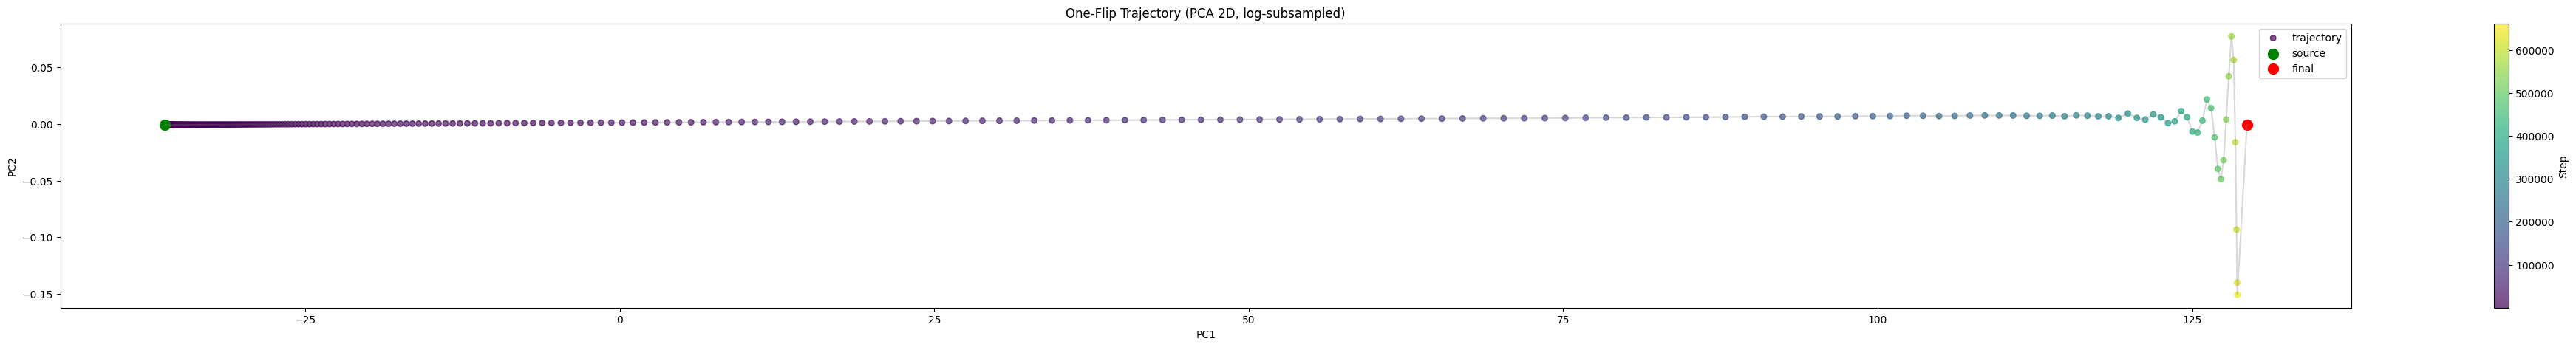

In [32]:
import numpy as np
import matplotlib.pyplot as plt

def subsample_logspace(N, max_points):
    """
    Subsample indices over [0, N) using log spacing, 
    to capture early detail and sparser later.
    """
    if N <= max_points:
        return np.arange(N)
    # log-space between 1 and N
    idxs = np.unique(
        np.floor(
            np.logspace(0, np.log10(N-1), max_points, base=10)
        ).astype(int)
    )
    return idxs

def visualize_oneflip_trajectory_improved(source_hidden, result, n_components=2, max_points=500):
    """
    Improved PCA-based 2D trajectory plot:
      - Logarithmic subsampling to highlight early steps.
      - Color gradient by step index.
      - Transparency for clarity.
    """
    source_np = source_hidden.detach().cpu().numpy()
    deltas = np.stack([d.detach().cpu().numpy() for d in result['trajectory']])
    N, D = deltas.shape

    # Subsample with log spacing
    idxs = subsample_logspace(N, max_points)
    deltas_sub = deltas[idxs]
    steps_sub = idxs + 1  # 1-based step numbers

    # Compute hidden states for sampled deltas
    hidden_sub = deltas_sub + source_np[None, :]
    final_np = source_np + result['perturbation'].detach().cpu().numpy()
    
    # Build PCA dataset on subsample + endpoints
    all_states = np.vstack([source_np, hidden_sub, final_np])
    mean = all_states.mean(axis=0)
    centered = all_states - mean
    _, _, Vt = np.linalg.svd(centered, full_matrices=False)
    comps = Vt[:n_components]
    coords = centered.dot(comps.T)

    # Extract coords
    coords_sub = coords[1:1+len(idxs)]
    coord_source = coords[0]
    coord_final = coords[-1]

    # Plot with color gradient and alpha
    plt.figure(figsize=(50,5))
    sc = plt.scatter(coords_sub[:,0], coords_sub[:,1], c=steps_sub, cmap='viridis',
                     s=30, alpha=0.7, label='trajectory')
    plt.plot(coords_sub[:,0], coords_sub[:,1], color='gray', alpha=0.3)
    plt.scatter(coord_source[0], coord_source[1], c='green', s=100, label='source')
    plt.scatter(coord_final[0], coord_final[1], c='red', s=100, label='final')
    plt.xlabel('PC1'); plt.ylabel('PC2')
    plt.title('One-Flip Trajectory (PCA 2D, log-subsampled)')
    plt.legend()
    cbar = plt.colorbar(sc, label='Step')
    plt.show()

# Example usage:
visualize_oneflip_trajectory_improved(source_hidden, result)

# SAE

In [ ]:
# def analyze_sae_code_polytope_transition(
#     sparse_code_start: torch.Tensor,
#     sparse_code_target: torch.Tensor,
#     step_size: float = 0.01,
#     support_weight: float = 0.0,
#     verbose: bool = True
# ) -> dict:
#     """
#     Analyze transitions between polytopes in SAE sparse code space.

#     Adds hybrid loss and metrics:
#     - MSE loss + optional support alignment loss
#     - Hamming distance and Jaccard score
#     """
#     delta = torch.zeros_like(sparse_code_start, requires_grad=True)
#     optimizer = torch.optim.Adam([delta], lr=step_size)

#     original_support = (sparse_code_start > 0).float()
#     target_support = (sparse_code_target > 0).float()
#     previous_support = original_support.clone()

#     boundary_count = 0
#     feature_flip_count = 0
#     flip_events = []
#     trajectory = []
#     metrics = []

#     visited_supports = set()
#     visited_supports.add(tuple(original_support.cpu().numpy().astype(int).tolist()))

#     best_delta = None
#     best_loss = float('inf')

#     step = 0
#     while True:
#         optimizer.zero_grad()
#         current_code = sparse_code_start + delta
#         current_support = (current_code > 0).float()

#         # Polytope support tracking
#         current_support_tuple = tuple(current_support.cpu().numpy().astype(int).tolist())
#         if current_support_tuple not in visited_supports:
#             visited_supports.add(current_support_tuple)
#             boundary_count += 1

#         # Count flips
#         flip = (current_support != previous_support).float()
#         flipped_indices = (flip == 1).nonzero(as_tuple=True)[0].tolist()
#         flip_events.extend(flipped_indices)
#         feature_flip_count += len(flipped_indices)

#         # Alignment metrics
#         mse = F.mse_loss(current_code, sparse_code_target).item()
#         hamming = (current_support != target_support).sum().item()
#         jaccard = support_jaccard(current_code, sparse_code_target)

#         metrics.append({
#             'step': step,
#             'mse': mse,
#             'hamming': hamming,
#             'jaccard': jaccard,
#             'delta_norm': delta.norm().item()
#         })

#         if verbose and step % 100 == 0:
#             print(f"Step {step}: MSE = {mse:.6f}, ||δ|| = {delta.norm().item():.2f}, "
#                   f"Hamming = {hamming}, Jaccard = {jaccard:.4f}, flips = {feature_flip_count}, "
#                   f"boundaries = {boundary_count}")

#         previous_support = current_support.clone()

#         # Hybrid loss: MSE + λ * support alignment loss (optional)
#         loss = F.mse_loss(current_code, sparse_code_target)
#         if support_weight > 0:
#             support_loss = F.l1_loss(current_support, target_support)
#             loss += support_weight * support_loss

#         if loss.item() < best_loss:
#             best_loss = loss.item()
#             best_delta = delta.detach().clone()

#         if mse < 1e-6 and hamming == 0:
#             if verbose:
#                 print(f"✅ Target SAE code reached at step {step}")
#                 print(f"Hamming distance to target support: {hamming}")
#             break

#         loss.backward()
#         optimizer.step()
#         trajectory.append(delta.detach().clone())
#         step += 1

#     if verbose:
#         print("\n=== SAE CODE POLYTOPE TRANSITION RESULTS ===")
#         print(f"Minimal perturbation: {best_delta.norm().item():.6f}")
#         print(f"SAE polytope boundaries crossed: {boundary_count}")
#         print(f"Total individual feature flips: {feature_flip_count}")
#         print(f"Unique polytopes visited: {len(visited_supports)}")
#         print(f"Target reached: {best_loss < 1e-3}")
#         print(f"Final loss: {best_loss:.6f}")
#         print(f"Optimization steps: {step}")

#     return {
#         'delta_min': best_delta.norm().item(),
#         'perturbation': best_delta,
#         'num_steps': step,
#         'sae_code_polytope_boundaries_crossed': boundary_count,
#         'total_feature_flips': feature_flip_count,
#         'unique_support_patterns': len(visited_supports),
#         'target_reached': best_loss < 1e-3,
#         'final_loss': best_loss,
#         'trajectory': trajectory,
#         'flip_events': flip_events,
#         'metrics': metrics
#     }

In [ ]:
def visualize_oneflip_trajectory_improved(source, result, n_components=2, max_points=500):
    source_np = source.detach().cpu().numpy()
    deltas = np.stack([d.detach().cpu().numpy() for d in result['trajectory']])
    N,_ = deltas.shape

    idxs = subsample_logspace(N, max_points)
    deltas_sub = deltas[idxs]
    steps_sub = idxs + 1

    # reconstruct code‐states
    states = deltas_sub + source_np[None,:]
    final = source_np + result['perturbation'].detach().cpu().numpy()
    all_states = np.vstack([source_np, states, final])
    mean = all_states.mean(axis=0)
    centered = all_states - mean
    _,_,Vt = np.linalg.svd(centered, full_matrices=False)
    comps = Vt[:n_components]
    coords = centered.dot(comps.T)

    coords_sub = coords[1:1+len(idxs)]
    src_c  = coords[0]
    fin_c  = coords[-1]

    plt.figure(figsize=(6,5))
    sc = plt.scatter(coords_sub[:,0], coords_sub[:,1], c=steps_sub, cmap='viridis', s=30, alpha=0.7)
    plt.plot(coords_sub[:,0], coords_sub[:,1], color='gray', alpha=0.3)
    plt.scatter(src_c[0], src_c[1], c='green', s=80, label='start')
    plt.scatter(fin_c[0], fin_c[1], c='red',   s=80, label='end')
    plt.colorbar(sc, label='step')
    plt.legend()
    plt.title('SAE Code Trajectory (PCA 2D, log‐subsampled)')
    plt.xlabel('PC1'); plt.ylabel('PC2')
    plt.show()

def visualize_step_distances(source, result, max_points=500):
    source_np = source.detach().cpu().numpy()
    deltas = np.stack([d.detach().cpu().numpy() for d in result['trajectory']])
    N,_ = deltas.shape

    norms = np.linalg.norm(deltas, axis=1)
    steps = np.arange(1, N+1)

    # color by polytope hash
    supports = ((deltas + source_np[None,:])>0).astype(int)
    hashes = np.array([hash(s.tobytes()) for s in supports])
    _, inv = np.unique(hashes, return_inverse=True)

    idxs = subsample_logspace(N, max_points)
    steps_sub = steps[idxs]
    norms_sub = norms[idxs]
    poly_sub = inv[idxs]

    plt.figure(figsize=(8,4))
    sc = plt.scatter(steps_sub, norms_sub, c=poly_sub, cmap='tab20', s=20)
    plt.plot(steps_sub, norms_sub, color='gray', alpha=0.4)
    plt.colorbar(sc, label='polytope ID')
    plt.xlabel('step'); plt.ylabel('‖δ‖₂')
    plt.title('Per‐Step Perturbation Norm (log‐subsampled)')
    plt.grid(True)
    plt.show()

# --- Example Usage ---
# res = analyze_sae_code_polytope_transition(code_start, code_target, support_weight=1.0)



In [43]:
import torch
import torch.nn.functional as F
import math

# make sure you have this helper
def support_jaccard(code, target_code):
    # intersection over union of supports
    s, t = (code>0).float(), (target_code>0).float()
    inter = (s*t).sum()
    union = ( (s+t)>0 ).float().sum()
    return (inter/union).item() if union>0 else 1.0

def analyze_sae_code_polytope_transition(
    sparse_code_start: torch.Tensor,
    sparse_code_target: torch.Tensor,
    step_size: float = 0.01,
    support_weight: float = 0.0,
    hinge_margin: float = 0.0,
    verbose: bool = True
) -> dict:
    """
    Hybrid hinge+MSE attack in sparse-code space, with full logging.
    """
    # Masks & metrics
    original_support = (sparse_code_start > 0).float()
    target_support   = (sparse_code_target > 0).float()
    initial_hamming  = int((original_support != target_support).sum().item())
    if verbose:
        print(f"Initial Hamming = {initial_hamming}")

    # Early exit
    if initial_hamming == 0:
        if verbose:
            print("✅ Already matched, no steps needed.")
        return {
            'perturbation': torch.zeros_like(sparse_code_start),
            'trajectory': [sparse_code_start.clone()],
            'initial_hamming': 0,
            'final_hamming': 0,
            'num_steps': 0,
            'success': True
        }

    # Set up
    delta = torch.zeros_like(sparse_code_start, requires_grad=True)
    optimizer = torch.optim.Adam([delta], lr=step_size)

    previous_support = original_support.clone()
    visited_supports = { tuple(original_support.int().cpu().tolist()) }
    boundary_count = 0
    feature_flip_count = 0
    flip_events = []

    trajectory = []
    metrics = []

    best_delta = None
    best_loss = float('inf')
    step = 0

    while True:
        optimizer.zero_grad()
        current_code = sparse_code_start + delta
        trajectory.append(delta.detach().clone())

        # support pattern & flips
        current_support = (current_code > 0).float()
        supp_tuple = tuple(current_support.int().cpu().tolist())
        if supp_tuple not in visited_supports:
            visited_supports.add(supp_tuple)
            boundary_count += 1

        flips = (current_support != previous_support)
        flipped_idx = flips.nonzero(as_tuple=True)[0].tolist()
        feature_flip_count += len(flipped_idx)
        flip_events.extend(flipped_idx)

        previous_support = current_support.clone()

        # compute losses & metrics
        mse     = F.mse_loss(current_code, sparse_code_target).item()
        hamming = int((current_support != target_support).sum().item())
        jaccard = support_jaccard(current_code, sparse_code_target)
        loss    = F.mse_loss(current_code, sparse_code_target)
        if support_weight > 0:
            support_loss = F.l1_loss(current_support, target_support)
            loss = loss + support_weight * support_loss

        # record best
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_delta = delta.detach().clone()

        # logging
        metrics.append({
            'step': step,
            'mse': mse,
            'hamming': hamming,
            'jaccard': jaccard,
            'delta_norm': delta.norm().item(),
            'flips': len(flipped_idx),
            'boundaries': boundary_count
        })

        if verbose and step % 100 == 0:
            print(f"Step {step:5d}: MSE = {mse:.6f}, ‖δ‖ = {delta.norm():.4f}, "
                  f"Hamming = {hamming}, Jaccard = {jaccard:.4f}, "
                  f"flips = {feature_flip_count}, boundaries = {boundary_count}")

        # stopping
        if hamming == 0 and mse < 1e-6:
            if verbose:
                print(f"✅ Reached target at step {step}, final ‖δ‖ = {best_delta.norm():.4f}")
            break

        # step
        loss.backward()
        optimizer.step()
        step += 1

    # final stats
    final_code = sparse_code_start + best_delta
    final_support = (final_code > 0).float()
    final_hamming = int((final_support != target_support).sum().item())
    l2_to_target = float((final_code - sparse_code_target).norm().item())

    if verbose:
        print(f"Final Hamming = {final_hamming}, L2 to target = {l2_to_target:.4f}")

    return {
        'perturbation': best_delta,
        'trajectory': trajectory,
        'initial_hamming': initial_hamming,
        'final_hamming': final_hamming,
        'num_steps': step,
        'sae_code_polytope_boundaries_crossed': boundary_count,
        'total_feature_flips': feature_flip_count,
        'unique_support_patterns': len(visited_supports),
        'final_loss': best_loss,
        'success': final_hamming == 0,
        'metrics': metrics
    }


In [24]:
import torch
import torch.nn.functional as F

def analyze_sae_code_polytope_transition_oneflip(
    sparse_code_start: torch.Tensor,
    sparse_code_target: torch.Tensor,
    max_iter: int = 10000,
    step_size: float = 0.01,
    hinge_margin: float = 0.0,
    stall_patience: int = 1000,
    min_step_size: float = 0.001,
    max_step_size: float = 1.0,
    mse_tol: float = 10.0,
    verbose: bool = True
) -> dict:
    """
    One-flip-per-step transition in SAE sparse-code space,
    with cosine annealing on step_size when MSE improvement < mse_tol
    for stall_patience steps, plus periodic logging.
    """
    delta = torch.zeros_like(sparse_code_start, requires_grad=True)
    target_support = (sparse_code_target > 0).float()

    visited_supports = {tuple((sparse_code_start>0).int().cpu().tolist())}

    trajectory = []
    margins = []

    # initial Hamming
    cur_sup = (sparse_code_start > 0).float()
    hamming_init = int((cur_sup != target_support).sum().item())
    if verbose:
        print(f"Initial Hamming: {hamming_init}")

    # stall tracking
    best_mse = float('inf')
    stall_counter = 0
    current_step_size = step_size

    step = 0
    while True:
        step += 1

        current_code = sparse_code_start + delta
        current_support = (current_code > 0).float()

        # compute mse + hinge
        mse = F.mse_loss(current_code, sparse_code_target)
        hinge_pos = F.relu(hinge_margin - current_code[target_support==1]).sum()
        hinge_neg = F.relu(current_code[target_support==0] + hinge_margin).sum()
        loss = mse + (hinge_pos + hinge_neg)

        # backprop
        loss.backward()
        with torch.no_grad():
            grad = delta.grad
            # update step size via cosine annealing if stalled
            if mse.item() < best_mse - mse_tol:
                best_mse = mse.item()
                stall_counter = 0
                current_step_size = step_size
            else:
                stall_counter += 1
                # cosine annealing
                if stall_counter >= stall_patience:
                    import math
                    frac = (stall_counter - stall_patience) / stall_patience
                    cosine = 0.5 * (1 + math.cos(math.pi * frac))
                    current_step_size = min_step_size + (max_step_size - min_step_size) * cosine

                    # make current_step_size at max max_step_size
                    current_step_size = max(current_step_size, max_step_size)

            proposed = - current_step_size * grad

            # record margin
            signs = current_code.sign()
            denom = proposed.abs().clamp_min(1e-8)
            margin_all = current_code.abs() / denom
            mask = (signs == -proposed.sign())
            margin = margin_all[mask].min().item() if mask.any() else float('inf')
            margins.append(margin)

            # enforce one-flip
            next_sup = ((current_code + proposed) > 0).float()
            flip_mask = (next_sup != current_support).float()
            if flip_mask.sum() > 1:
                dists = (current_code.abs() / denom)
                dists[~mask] = float('inf')
                idx = int(dists.argmin().item())
                scale = (current_code[idx].abs() / (denom[idx] + 1e-8)).item()
                proposed = proposed * (scale + 1e-4)

            delta.add_(proposed)
            delta.grad.zero_()

        trajectory.append(delta.clone())

        # track visited
        new_pat = tuple(((current_code + proposed)>0).int().cpu().tolist())
        visited_supports.add(new_pat)

        # periodic logging
        if verbose and step % 1000 == 0:
            cur_code = sparse_code_start + delta
            hamming = int(((cur_code>0).float() != target_support).sum().item())
            print(f"Step {step:5d} | Hamming: {hamming:3d} | "
                  f"Visited: {len(visited_supports):4d} | "
                  f"StepSize: {current_step_size:.5f} | MSE: {mse.item():.4f}" 
                    f"| Margin: {margin:.4f} | ||δ||: {delta.norm().item():.4f}")

        # stopping
        final_sup = (current_code + proposed > 0).float()
        if (final_sup != target_support).sum() == 0 and mse.item() < 1e-6:
            if verbose:
                print(f"✅ Matched at step {step}, ||δ||={delta.norm().item():.4f}")
            break

    # final stats
    final_code = sparse_code_start + delta
    final_hamming = int(((final_code>0).float() != target_support).sum().item())
    l2 = (final_code - sparse_code_target).norm().item()
    if verbose:
        print(f"Final Hamming: {final_hamming}, L2 to target: {l2:.4f}")

    return {
        'perturbation': delta.detach().clone(),
        'trajectory': trajectory,
        'margins': margins,
        'initial_hamming': hamming_init,
        'final_hamming': final_hamming,
        'num_steps': step,
        'visited_polytopes': len(visited_supports),
        'l2_to_target': l2,
        'success': final_hamming == 0
    }

In [25]:
# Test SAE polytope transition
print("\n" + "="*80)
print("ANALYZING SAE CODE POLYTOPE TRANSITION")
print("="*80)   

# Get initial and target SAE codes
source_sae_code = tracer.get_sae_code(source_hidden)
target_sae_code = tracer.get_sae_code(target_hidden)   
print(f"Source SAE code shape: {source_sae_code.shape}")
print(f"Target SAE code shape: {target_sae_code.shape}")
# Original polytope analysis
source_sae_polytope = (source_sae_code > 0).float()
target_sae_polytope = (target_sae_code > 0).float()
sae_polytope_hamming = (source_sae_polytope != target_sae_polytope).sum().item()
print(f"Source SAE polytope active dims: {source_sae_polytope.sum().item()}/{len(source_sae_polytope)}")
print(f"Target SAE polytope active dims: {target_sae_polytope.sum().item()}/{len(target_sae_polytope)}")
print(f"SAE polytope Hamming distance: {sae_polytope_hamming}")
# Run SAE polytope transition analysis

results = analyze_sae_code_polytope_transition(
    sparse_code_start=source_sae_code,
    sparse_code_target=target_sae_code
)


ANALYZING SAE CODE POLYTOPE TRANSITION
Source SAE code shape: torch.Size([65536])
Target SAE code shape: torch.Size([65536])
Source SAE polytope active dims: 158.0/65536
Target SAE polytope active dims: 223.0/65536
SAE polytope Hamming distance: 229


NameError: name 'analyze_sae_code_polytope_transition' is not defined

In [26]:
# Test SAE polytope transition
print("\n" + "="*80)
print("ANALYZING SAE CODE POLYTOPE TRANSITION")
print("="*80)   

# Get initial and target SAE codes
source_sae_code = tracer.get_sae_code(source_hidden)
target_sae_code = tracer.get_sae_code(target_hidden)   
print(f"Source SAE code shape: {source_sae_code.shape}")
print(f"Target SAE code shape: {target_sae_code.shape}")
# Original polytope analysis
source_sae_polytope = (source_sae_code > 0).float()
target_sae_polytope = (target_sae_code > 0).float()
sae_polytope_hamming = (source_sae_polytope != target_sae_polytope).sum().item()
print(f"Source SAE polytope active dims: {source_sae_polytope.sum().item()}/{len(source_sae_polytope)}")
print(f"Target SAE polytope active dims: {target_sae_polytope.sum().item()}/{len(target_sae_polytope)}")
print(f"SAE polytope Hamming distance: {sae_polytope_hamming}")
# Run SAE polytope transition analysis

sae_results_oneflip = analyze_sae_code_polytope_transition_oneflip(
    sparse_code_start=source_sae_code,
    sparse_code_target=target_sae_code)


ANALYZING SAE CODE POLYTOPE TRANSITION
Source SAE code shape: torch.Size([65536])
Target SAE code shape: torch.Size([65536])
Source SAE polytope active dims: 158.0/65536
Target SAE polytope active dims: 223.0/65536
SAE polytope Hamming distance: 229
Initial Hamming: 229
Step  1000 | Hamming:  72 | Visited:   12 | StepSize: 0.01000 | MSE: 0.1720| Margin: 0.0000 | ||δ||: 34.7216
Step  2000 | Hamming:  65 | Visited:   19 | StepSize: 1.00000 | MSE: 0.1714| Margin: 0.0000 | ||δ||: 35.4719
Step  3000 | Hamming:  62 | Visited:   22 | StepSize: 1.00000 | MSE: 0.1709| Margin: 0.0000 | ||δ||: 36.1876
Step  4000 | Hamming:  60 | Visited:   24 | StepSize: 1.00000 | MSE: 0.1704| Margin: 0.0000 | ||δ||: 36.8798
Step  5000 | Hamming:  55 | Visited:   29 | StepSize: 1.00000 | MSE: 0.1700| Margin: 0.0000 | ||δ||: 37.5296
Step  6000 | Hamming:  54 | Visited:   30 | StepSize: 1.00000 | MSE: 0.1695| Margin: 0.0000 | ||δ||: 38.1499
Step  7000 | Hamming:  50 | Visited:   34 | StepSize: 1.00000 | MSE: 0.169

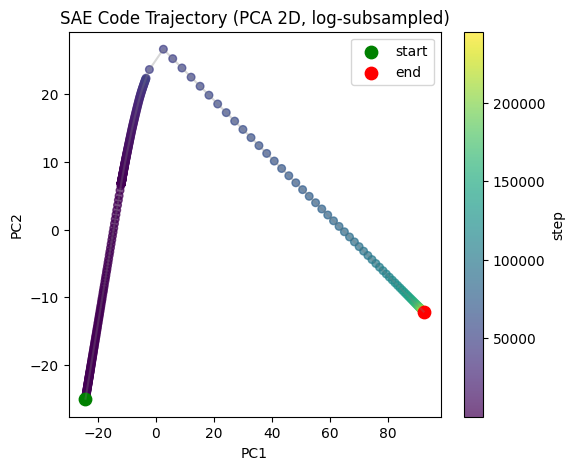

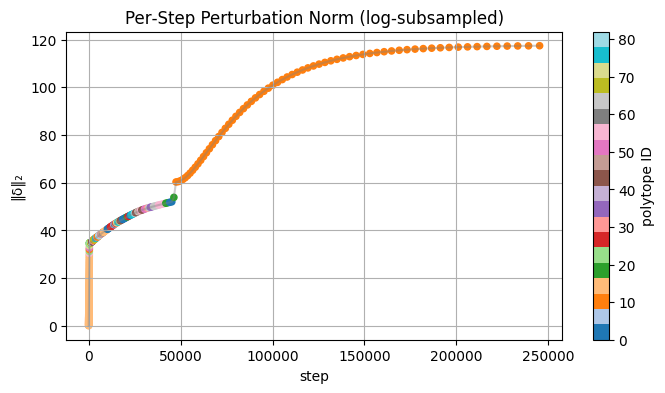

In [29]:
visualize_oneflip_trajectory_improved(source_sae_code, sae_results_oneflip)
visualize_step_distances(source_sae_code, sae_results_oneflip)

In [30]:
# save sae_results_oneflip
import pickle
with open('sae_results_oneflip.pkl', 'wb') as f:
    pickle.dump(sae_results_oneflip, f)

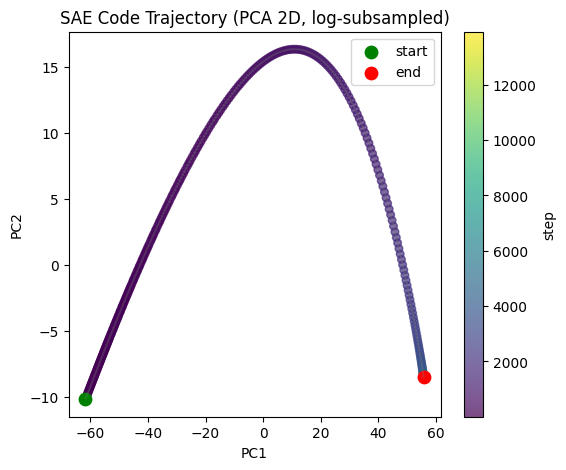

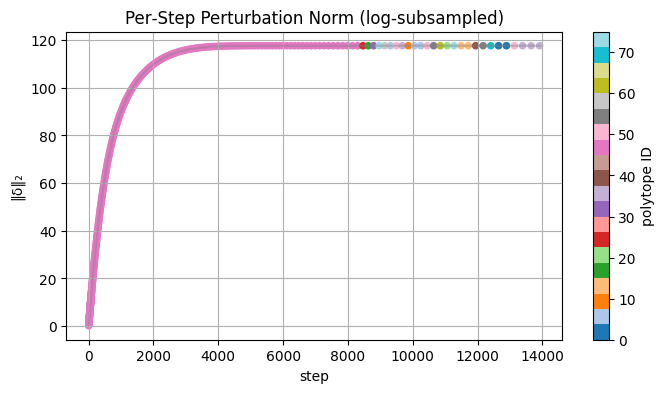

In [45]:
visualize_oneflip_trajectory_improved(source_sae_code, results)
visualize_step_distances(source_sae_code, results)

In [28]:
# Test SAE polytope transition
print("\n" + "="*80)
print("ANALYZING SAE CODE POLYTOPE TRANSITION")
print("="*80)   

# Get initial and target SAE codes
source_sae_code = tracer.get_sae_code(source_hidden)
target_sae_code = tracer.get_sae_code(target_hidden)   
print(f"Source SAE code shape: {source_sae_code.shape}")
print(f"Target SAE code shape: {target_sae_code.shape}")
# Original polytope analysis
source_sae_polytope = (source_sae_code > 0).float()
target_sae_polytope = (target_sae_code > 0).float()
sae_polytope_hamming = (source_sae_polytope != target_sae_polytope).sum().item()
print(f"Source SAE polytope active dims: {source_sae_polytope.sum().item()}/{len(source_sae_polytope)}")
print(f"Target SAE polytope active dims: {target_sae_polytope.sum().item()}/{len(target_sae_polytope)}")
print(f"SAE polytope Hamming distance: {sae_polytope_hamming}")
# Run SAE polytope transition analysis

results = analyze_sae_code_polytope_transition(
    sparse_code_start=source_sae_code,
    sparse_code_target=target_sae_code
)


ANALYZING SAE CODE POLYTOPE TRANSITION
Source SAE code shape: torch.Size([65536])
Target SAE code shape: torch.Size([65536])
Source SAE polytope active dims: 158.0/65536
Target SAE polytope active dims: 223.0/65536
SAE polytope Hamming distance: 229
Step 100: MSE = 0.164879, ||δ|| = 16.16, Hamming = 82, Jaccard = 0.7311, flips = 147, boundaries = 1
Step 200: MSE = 0.128883, ||δ|| = 30.30, Hamming = 82, Jaccard = 0.7311, flips = 147, boundaries = 1
Step 300: MSE = 0.101355, ||δ|| = 42.60, Hamming = 82, Jaccard = 0.7311, flips = 147, boundaries = 1
Step 400: MSE = 0.080336, ||δ|| = 53.18, Hamming = 82, Jaccard = 0.7311, flips = 147, boundaries = 1
Step 500: MSE = 0.064224, ||δ|| = 62.19, Hamming = 82, Jaccard = 0.7311, flips = 147, boundaries = 1
Step 600: MSE = 0.051758, ||δ|| = 69.80, Hamming = 82, Jaccard = 0.7311, flips = 147, boundaries = 1
Step 700: MSE = 0.041996, ||δ|| = 76.19, Hamming = 82, Jaccard = 0.7311, flips = 147, boundaries = 1
Step 800: MSE = 0.034254, ||δ|| = 81.58, H